In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re

In [2]:
GAMMAS = ['1.0','0.9','0.8','0.7','0.6','0.5','0.4','0.3','0.2','0.1']
INDEX_TIME_UNIT = 1000 # number of tweets
QUERY_TIME_UNIT = 1000 # number of tweets
SIMILARITY_THRE = 0.5
NUMBER_OF_RUNS = 3
OUTPUT_DIR = "./output_expm1/n10/"

def get_chance(gamma):
    if gamma == '1.0':
        return '100'
    elif gamma == '0.9':
        return '90'
    elif gamma == '0.8':
        return '80'
    elif gamma == '0.7':
        return '70'
    elif gamma == '0.6':
        return '60'
    elif gamma == '0.5':
        return '50'
    elif gamma == '0.4':
        return '40'
    elif gamma == '0.3':
        return '30'
    elif gamma == '0.2':
        return '20'
    elif gamma == '0.1':
        return '10'
    
def get_gamma_index(gamma):
    if gamma == '1.0':
        return 0
    elif gamma == '0.9':
        return 1
    elif gamma == '0.8':
        return 2
    elif gamma == '0.7':
        return 3
    elif gamma == '0.6':
        return 4
    elif gamma == '0.5':
        return 5
    elif gamma == '0.4':
        return 6
    elif gamma == '0.3':
        return 7
    elif gamma == '0.2':
        return 8
    elif gamma == '0.1':
        return 9
    
SUMMARY_INDEX = pd.Index(['Run', 'Chance', 'Index time unit', 'Query time unit', 'Similarity threshold', 
                 'Query counts', 'Indexed tweet counts', 'Index size'])
SUMMARY_COL = ['Summary_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RESULT_COL = ['Result_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_SIMILARITY_COL = ['Similarity_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LOOKUPS_COL = ['Lookups_' + get_chance(p) + '%' for p in GAMMAS]
INDEX_TIME_COL = ['Index_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]
QUERY_TIME_COL = ['Query_time_run{}_{}%'.format(str(i+1), get_chance(p)) for p in GAMMAS for i in range(NUMBER_OF_RUNS)]

FREQ_TABLES_X = ['Posting_list_length_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_RECALL_X = ['Query_recall_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_PRECISION_X = ['Query_precision_' + get_chance(p) + '%' for p in GAMMAS]
QUERY_LESS_LOOKUPS_X = ['Query_of_less_lookups_' + get_chance(p) + '%' for p in GAMMAS]
AVERAGE_LOOKUPS_X = ['Average_lookup_counts_' + get_chance(p) + '%' for p in GAMMAS]
PLOT_X = [get_chance(p) + '%' for p in GAMMAS]

# Run Experiment  One and Read in Results

* Use single terms to construct index
* Each term has a 100% chance to 50% chance to be included in the index or fingerprint

In [3]:
def runSketchTweets(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, n, output_dir):
    for run in range (1, n+1):
        os.system("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))
        print("java -jar ./{}.jar -iu {} -qu {} -p {} -s {} -n {} -o {}"
        .format(jar, index_time_unit, query_time_unit, chance_gamma, similarity_threshold, run, output_dir))

In [4]:
# This function runs the experiment and compares the results including:
# - the size of the index and doc lists 
# - time for constructing the index and executing query 
# - number of lookups before finding the match

def run_expm1():
    for p in GAMMAS:
        runSketchTweets("SketchingTweet-v1_n10", INDEX_TIME_UNIT, QUERY_TIME_UNIT, p, SIMILARITY_THRE, NUMBER_OF_RUNS, OUTPUT_DIR)
    results = load_expm1_csv(OUTPUT_DIR)
    return results

In [5]:
def load_expm1_csv(directory):
    '''
    Returns a dictionary of results.
    The dictionary keys are: summary, termfreq, query_results_similarity_lookups, index_time, query_time
    '''
    results = {}
    summary = [0] * len(GAMMAS)
    termfreq = [0] * len(GAMMAS)
    query_result = [0] * len(GAMMAS)
    query_similarity = [0] * len(GAMMAS)
    query_lookups = [0] * len(GAMMAS)
    index_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
    query_time = [[0 for j in range(NUMBER_OF_RUNS)] for i in range(len(GAMMAS))]
      

    for root, _, files in os.walk(directory):
        for file in files:
            filename = re.match( r'Epoch_(\d+)_iu_(\d+)_qu_(\d+)_p_([\.\d]+)_s_([\.\d]+)_(.+).csv', file)
#             print(filename)
#             print(filename.group(3),filename.group(4),filename.group(5),filename.group(6))
            name = filename.group(6)
            gamma = filename.group(4)

            if name == "summary":    
                for p in GAMMAS:
                    if gamma == p:
                        summary[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)

            if name == "term_freq":
                for p in GAMMAS:
                    if gamma == p:
                        termfreq[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_result":
                for p in GAMMAS:
                    if gamma == p:
                        query_result[get_gamma_index(gamma)] = pd.read_csv(directory + file, header=None)
                    
            if name == "query_similarity":
                for p in GAMMAS:
                    if gamma == p:
                        query_similarity[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "lookups":
                for p in GAMMAS:
                    if gamma == p:
                        query_lookups[get_gamma_index(gamma)] = pd.read_csv(directory + "/" + file, header=None)
            
            if name == "index_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                index_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                    
            if name == "query_time":
                run = filename.group(1)
                for p in GAMMAS:
                    if gamma == p:
                        for i in range(0,NUMBER_OF_RUNS):
                            if run == str(i+1):
                                query_time[get_gamma_index(gamma)][i] = pd.read_csv(directory + "/" + file, header=None)
                  
    
    summary = pd.concat(summary, 1)
    summary = summary.set_index(SUMMARY_INDEX)
    summary.columns = SUMMARY_COL
#     print(summary)
    
    for table in termfreq:
        termfreq_index = table.iloc[:,0]
        table.set_index(termfreq_index, inplace=True)
        table.drop(table.columns[0], axis=1, inplace=True)
        table.columns = ['number_of_terms', 'posting_count']
#     print(termfreq)
    
    query_result = pd.concat(query_result, 1)
    query_result.columns = QUERY_RESULT_COL
#     print(query_result)
    
    query_similarity = pd.concat(query_similarity, 1)
    query_similarity.columns = QUERY_SIMILARITY_COL
#     print(query_similarity)

    query_lookups = pd.concat(query_lookups, 1)
    query_lookups.columns = QUERY_LOOKUPS_COL
#     print(query_lookups)

    query_result_similarity_lookup = [query_result, query_similarity, query_lookups]
    query_result_similarity_lookup = pd.concat(query_result_similarity_lookup, 1)
#     print(query_result_similarity_lookup)
    
    index_time_dfs = []
    for p in index_time:
        index_time_df = pd.concat(p, 1)
        index_time_dfs.append(index_time_df)
    index_time = pd.concat(index_time_dfs, 1)
    index_time.columns = INDEX_TIME_COL
    
    query_time_dfs = []
    for p in query_time:
        query_time_df = pd.concat(p, 1)
        query_time_dfs.append(query_time_df)
    query_time = pd.concat(query_time_dfs, 1)
    query_time.columns = QUERY_TIME_COL
    
    results['summary'] = summary
    results['termfreq'] = termfreq
    results['query_result_similarity_lookup'] = query_result_similarity_lookup
    results['index_time'] = index_time
    results['query_time'] = query_time
  
    return results

results = run_expm1() 

java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 1 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 2 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 1.0 -s 0.5 -n 3 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 1 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 2 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.9 -s 0.5 -n 3 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 1 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 2 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.8 -s 0.5 -n 3 -o ./output_expm1/n10/
java -jar ./SketchingTweet-v1_n10.jar -iu 1000 -qu 1000 -p 0.7 -s 0.5 -n 1 -o ./output_expm1/n10/
java -jar ./Sketchin

# Process Results

In [6]:
def plot_linechart(title, x, y, x_label, y_label, scale='linear'):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_scatter(title, x, y, x_label, y_label, scale='linear'):
    plt.scatter(x, y, s=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()
    
def plot_barchart(title, x, y, x_label, y_label, color="#66B3BA"):
    layer = sns.barplot(x=x, y=y, color=color)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def plot_boxplot(title, data, y_label, scale='linear'):
    layer = sns.boxplot(data=data)
    layer = sns.stripplot(data=data, color="orange", jitter=0.2, size=1.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.yscale(scale)
    plt.show()

## Index size comparison

In [7]:
summary = results['summary']
summary

,Summary_100%,Summary_90%,Summary_80%,Summary_70%,Summary_60%,Summary_50%,Summary_40%,Summary_30%,Summary_20%,Summary_10%
Run,1,1,1,1,1,1,1,1,1,1
Chance,100.0%,90.0%,80.0%,70.0%,60.0%,50.0%,40.0%,30.0%,20.0%,10.0%
Index time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Query time unit,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Similarity threshold,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Query counts,21890,21890,21890,21890,21890,21890,21890,21890,21890,21890
Indexed tweet counts,197610,197610,197610,197610,197610,197610,197610,197610,197610,197610
Index size,3170464,1294171,1260341,1218484,1164905,1094984,1002456,872117,678757,383231


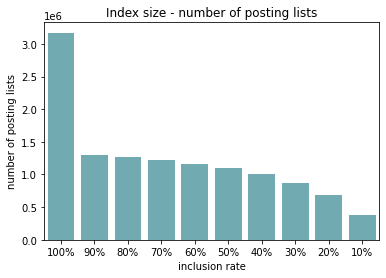

Summary_100%    3170464
Summary_90%     1294171
Summary_80%     1260341
Summary_70%     1218484
Summary_60%     1164905
Summary_50%     1094984
Summary_40%     1002456
Summary_30%      872117
Summary_20%      678757
Summary_10%      383231
Name: Index size, dtype: object

In [8]:
# index size - number of posting lists
def compare_index_size(sizes, title):
    data = pd.to_numeric(sizes).to_list()
    plot_barchart(title, PLOT_X, data, 'inclusion rate', 'number of posting lists')

compare_index_size(summary.loc['Index size'], "Index size - number of posting lists")
summary.loc['Index size']

## Documnet list length comparison

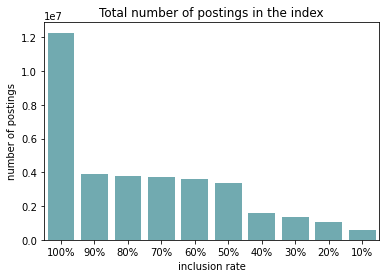

Total number of postings:


[12270960,
 3884344,
 3804546,
 3709584,
 3578522,
 3395268,
 1565994,
 1375804,
 1079053,
 602244]

In [9]:
freq_tables = results['termfreq']
posting_list_length_distribution = [table['posting_count'].value_counts().sort_index(inplace=False) for table in freq_tables]
total_posting_counts = [sum(table['posting_count']) for table in freq_tables]
plot_barchart('Total number of postings in the index', PLOT_X, total_posting_counts, 'inclusion rate', 'number of postings')
print('Total number of postings:')
total_posting_counts

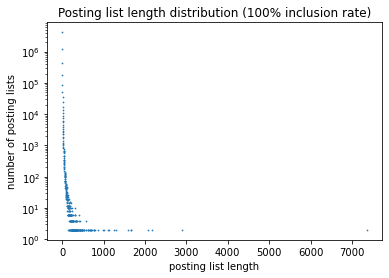

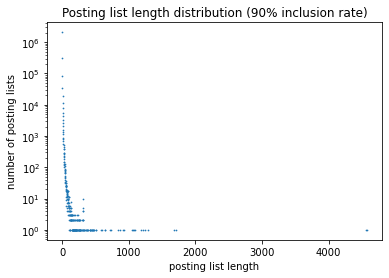

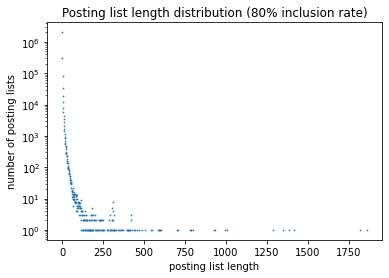

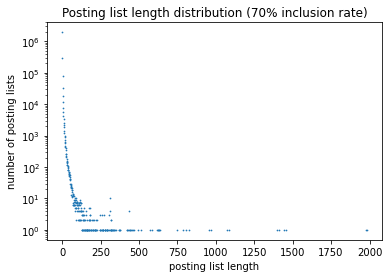

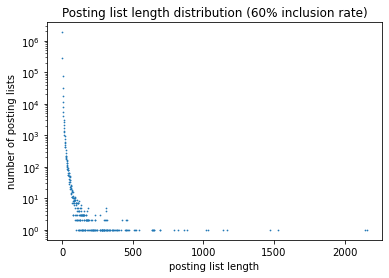

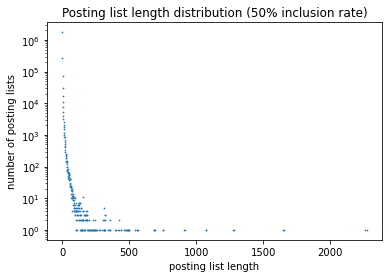

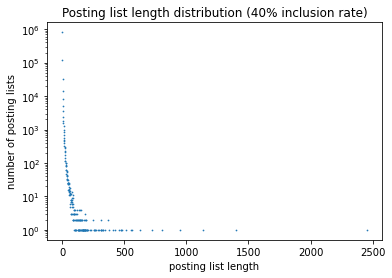

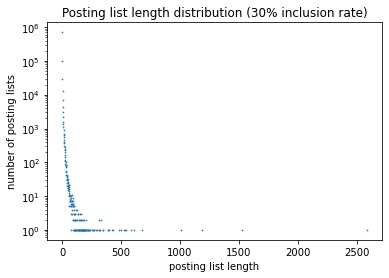

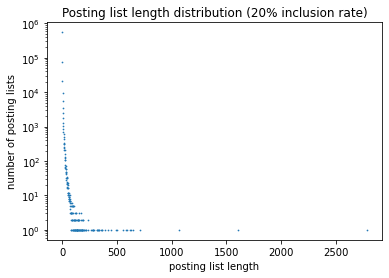

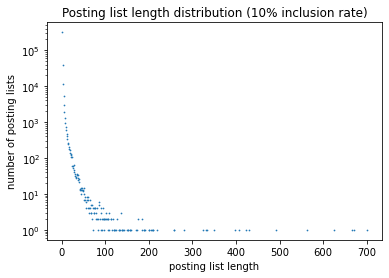

In [10]:
def compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution):
    for i in range(len(PLOT_X)):
        title = f'Posting list length distribution ({PLOT_X[i]} inclusion rate)'
        x = posting_list_length_distribution[i].index
        y = posting_list_length_distribution[i]
        plot_scatter(title, x, y, 'posting list length', 'number of posting lists', scale='log')   
compare_postinglist_length_distribution(PLOT_X, posting_list_length_distribution)

Average posting list length
[1.9351993903731441, 1.5007491490455014, 1.5096014970050375, 1.5222215930214522, 1.5359360031315132, 1.5505071516349367, 1.5621573415691064, 1.5775452146902307, 1.5897486140106105, 1.5714908240721654]


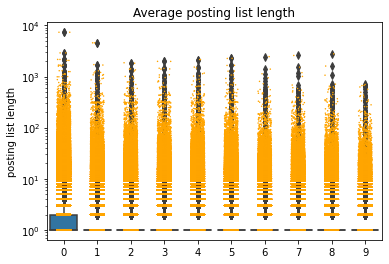

In [11]:
def compare_posting_list_len(PLOT_X, freq_tables):
    lengths = [table['posting_count'] for table in freq_tables]
    avgs = [sum(l)/len(l) for l in lengths]
    print("Average posting list length")
    print(avgs)
#     index15 = [int(round(len(l)*0.15,0)) for l in lengths]
#     index85 = [int(round(len(l)*0.85,0)) for l in lengths]
#     nooutlier_lengths = [ lengths[i][index15[i]:index85[i]] for i in range(len(lengths))]
    plot_boxplot(f'Average posting list length', lengths, 'posting list length', scale='log')
    
compare_posting_list_len(PLOT_X, freq_tables)

## Query Recall - compare to single term gamma=1 result

In [12]:
truth = pd.read_csv('./single_term_ground_truth.csv', header=None)

In [13]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,-1,-1,-1,-1,-1,-1,26531,189567,189567,...,22055,-1,-1,-1,-1,-1,-1,400,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,11620,2470,2730,198,176,175,175,125,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,-1,-1,139648,139648,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1
21886,-1,-1,-1,-1,-1,-1,-1,-1,-1,91619,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
21887,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [14]:
has_true_similar = truth[0] != -1
true_similar = truth[has_true_similar]
term_pair_results = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
has_true_similar
true_similar

,0
0,189567
1,146028
8,44802
12,170152
15,102434
...,...
21878,197554
21880,197554
21881,93654
21884,178680


In [15]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[0] == term_pair_results[QUERY_RESULT_COL[i]]
    correct_search = term_pair_results[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[2761, 1269, 1408, 1613, 1867, 2114, 2479, 2742, 3020, 2573]

Using 100% of terms, we can find 38.1% truly similar tweets
Using 90% of terms, we can find 17.51% truly similar tweets
Using 80% of terms, we can find 19.43% truly similar tweets
Using 70% of terms, we can find 22.26% truly similar tweets
Using 60% of terms, we can find 25.76% truly similar tweets
Using 50% of terms, we can find 29.17% truly similar tweets
Using 40% of terms, we can find 34.21% truly similar tweets
Using 30% of terms, we can find 37.84% truly similar tweets
Using 20% of terms, we can find 41.67% truly similar tweets
Using 10% of terms, we can find 35.5% truly similar tweets


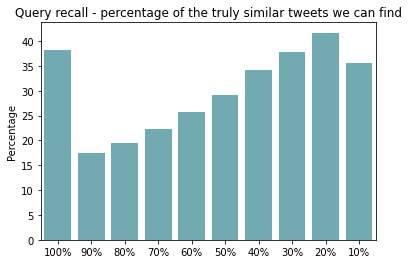

In [16]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Recall - compare to term pair gamma=1 result

In [17]:
query_result_similarity_lookup = results['query_result_similarity_lookup']
query_result_similarity_lookup

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,-1,-1,-1,-1,-1,-1,26531,189567,189567,...,22055,-1,-1,-1,-1,-1,-1,400,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,11620,2470,2730,198,176,175,175,125,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,-1,-1,-1,-1,-1,-1,-1,-1,139648,139648,...,-1,-1,-1,-1,-1,-1,-1,-1,2,1
21886,-1,-1,-1,-1,-1,-1,-1,-1,-1,91619,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,2
21887,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21888,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [18]:
has_true_similar = query_result_similarity_lookup[QUERY_RESULT_COL[0]] != -1
true_similar = query_result_similarity_lookup[has_true_similar]
num_true_similar = true_similar.shape[0]
true_similar

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
0,26531,-1,-1,-1,-1,-1,-1,26531,189567,189567,...,22055,-1,-1,-1,-1,-1,-1,400,24,9
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,11620,2470,2730,198,176,175,175,125,1
18,196085,196085,196085,196085,196085,196085,196085,196085,196085,196085,...,30,16,16,6,6,4,3,3,3,2
26,73525,-1,-1,-1,-1,-1,-1,-1,-1,182442,...,930,-1,-1,-1,-1,-1,-1,-1,-1,2
29,1582,1582,1582,1582,1582,1582,1582,1582,1582,-1,...,2247,340,310,230,450,248,18,3,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21874,197342,197342,197342,197342,197342,197342,197342,197342,197342,197342,...,10,10,10,8,5,5,3,2,2,1
21875,197554,197550,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,10,10,10,10,10,10,4,2
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,10,10,10,10,10,10,10,4,2
21880,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,10,10,10,10,10,10,10,4,2


In [19]:
num_correct_searches = []
correct_searches = []
for i in range(len(QUERY_RESULT_COL)):
    is_correct_search = true_similar[QUERY_RESULT_COL[0]] == true_similar[QUERY_RESULT_COL[i]]
    correct_search = true_similar[is_correct_search]
    correct_searches.append(correct_search)
    num_correct_searches.append(correct_search.shape[0])
print('Number of true similar tweets that we found: ')
num_correct_searches

Number of true similar tweets that we found: 


[4226, 1876, 2100, 2348, 2656, 2752, 3083, 3087, 3034, 2483]

Using 100% of terms, we can find 100.0% truly similar tweets
Using 90% of terms, we can find 44.39% truly similar tweets
Using 80% of terms, we can find 49.69% truly similar tweets
Using 70% of terms, we can find 55.56% truly similar tweets
Using 60% of terms, we can find 62.85% truly similar tweets
Using 50% of terms, we can find 65.12% truly similar tweets
Using 40% of terms, we can find 72.95% truly similar tweets
Using 30% of terms, we can find 73.05% truly similar tweets
Using 20% of terms, we can find 71.79% truly similar tweets
Using 10% of terms, we can find 58.76% truly similar tweets


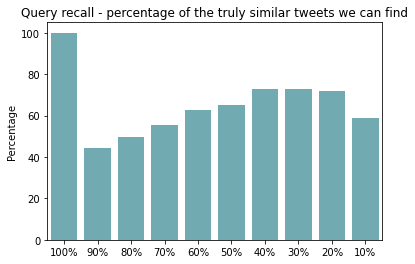

In [20]:
def compare_query_recall(recalls, title): 
    layer = sns.barplot(x=PLOT_X, y=recalls, color="#66B3BA")
    plt.title(title)
    layer.set(ylabel='Percentage')
    plt.show()

recalls = []
true_searches = []
for i in range(len(num_correct_searches)):
    true_searches.append(num_correct_searches[i])
    recall = round((num_correct_searches[i]/num_true_similar) * 100, 2)
    recalls.append(recall)
    chance = PLOT_X[i]
    print('Using {} of terms, we can find {}% truly similar tweets'.format(chance, recall))
    
compare_query_recall(recalls, 'Query recall - percentage of the truly similar tweets we can find')

## Query Precision

In [21]:
# is_predict_similar = query_result_similarity_lookup['Result_75%'] != -1
# predict_similar = query_result_similarity_lookup[is_predict_similar]
# num_predict_similar = predict_similar.shape[0]
# predict_similar
num_predict_similar_lst = []
predict_similar_lst = []
for i in range(len(QUERY_RESULT_COL)):
    is_predict_similar = query_result_similarity_lookup[QUERY_RESULT_COL[i]] != -1
    predict_similar = query_result_similarity_lookup[is_predict_similar]
    predict_similar_lst.append(predict_similar)
    num_predict_similar_lst.append(predict_similar.shape[0])
print("The number of tweets that we think are similar: ")
num_predict_similar_lst

The number of tweets that we think are similar: 


[4226, 2792, 2993, 3230, 3542, 3908, 4437, 5164, 6147, 7026]

Using 100% of terms, 100.0% tweets that we found similar are truly similar tweets
Using 90% of terms, 67.19% tweets that we found similar are truly similar tweets
Using 80% of terms, 70.16% tweets that we found similar are truly similar tweets
Using 70% of terms, 72.69% tweets that we found similar are truly similar tweets
Using 60% of terms, 74.99% tweets that we found similar are truly similar tweets
Using 50% of terms, 70.42% tweets that we found similar are truly similar tweets
Using 40% of terms, 69.48% tweets that we found similar are truly similar tweets
Using 30% of terms, 59.78% tweets that we found similar are truly similar tweets
Using 20% of terms, 49.36% tweets that we found similar are truly similar tweets
Using 10% of terms, 35.34% tweets that we found similar are truly similar tweets


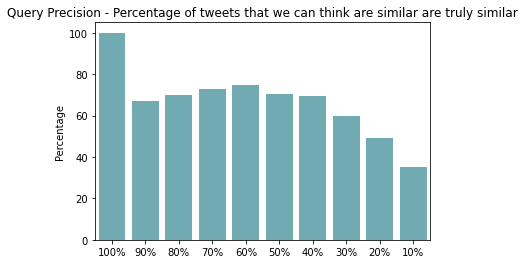

In [22]:
def compare_query_precision(precisions, title): 
    layer = sns.barplot(x=PLOT_X, y=precisions, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

precisions = []
for i in range(len(num_predict_similar_lst)):
    precision = round((num_correct_searches[i]/num_predict_similar_lst[i]) * 100, 2)
    precisions.append(precision)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% tweets that we found similar are truly similar tweets'.format(chance, precision))
    
compare_query_precision(precisions, 'Query Precision - Percentage of tweets that we can think are similar are truly similar')

## Number of searches that need fewer lookups

In [23]:
correct_search

,Result_100%,Result_90%,Result_80%,Result_70%,Result_60%,Result_50%,Result_40%,Result_30%,Result_20%,Result_10%,...,Lookups_100%,Lookups_90%,Lookups_80%,Lookups_70%,Lookups_60%,Lookups_50%,Lookups_40%,Lookups_30%,Lookups_20%,Lookups_10%
1,2559,2559,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,11620,2470,2730,198,176,175,175,125,1
18,196085,196085,196085,196085,196085,196085,196085,196085,196085,196085,...,30,16,16,6,6,4,3,3,3,2
30,2559,94382,2559,2559,2559,2559,2559,2559,2559,2559,...,112365,11140,2470,2730,198,176,175,175,125,1
40,708,708,708,708,708,708,708,708,708,708,...,330,20,80,10,100,70,10,10,6,1
55,196844,-1,-1,-1,-1,-1,-1,-1,38428,196844,...,819,-1,-1,-1,-1,-1,-1,-1,570,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21874,197342,197342,197342,197342,197342,197342,197342,197342,197342,197342,...,10,10,10,8,5,5,3,2,2,1
21875,197554,197550,197554,197554,197554,197554,197554,197554,197554,197554,...,21,20,10,10,10,10,10,10,4,2
21878,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,10,10,10,10,10,10,10,4,2
21880,197554,197554,197554,197554,197554,197554,197554,197554,197554,197554,...,21,10,10,10,10,10,10,10,4,2


In [24]:
query_of_less_lookups = []
less_search_lst = []
for i in range(len(QUERY_LOOKUPS_COL)):
    if i != 0:
        is_less_search = correct_searches[i][QUERY_LOOKUPS_COL[0]] > correct_searches[i][QUERY_LOOKUPS_COL[i]]
        less_search = correct_searches[i][is_less_search]
        less_search_lst.append(less_search)
        query_of_less_lookups.append(less_search.shape[0])
    else:
        less_search_lst.append(None)
        query_of_less_lookups.append(0)
print("The number of tweets that need less lookups before correctly finding the true similar tweets: ")
query_of_less_lookups

The number of tweets that need less lookups before correctly finding the true similar tweets: 


[0, 1821, 2096, 2348, 2656, 2752, 3083, 3087, 3034, 2483]

Using 100% of terms, 0.0% queries need less lookups before correctly finding the true similar tweets
Using 90% of terms, 97.07% queries need less lookups before correctly finding the true similar tweets
Using 80% of terms, 99.81% queries need less lookups before correctly finding the true similar tweets
Using 70% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 60% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 50% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 40% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 30% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 20% of terms, 100.0% queries need less lookups before correctly finding the true similar tweets
Using 10% of terms, 100.0% queries need less lookups before correctly finding the t

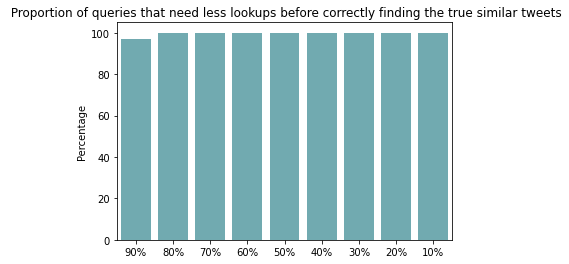

In [25]:
def compare_number_of_tweets_need_less_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X[1:], y=reduces, color="#66B3BA")
    layer.set(ylabel='Percentage')
    plt.title(title)
    plt.show()

proportions = []
for i in range(len(query_of_less_lookups)):
    proportion = round((query_of_less_lookups[i] / num_correct_searches[i]) * 100, 2)
    proportions.append(proportion)
    chance = PLOT_X[i]
    print('Using {} of terms, {}% queries need less lookups before correctly finding the true similar tweets'.format(chance, proportion))
    
compare_number_of_tweets_need_less_lookups(proportions[1:], ' Proportion of queries that need less lookups before correctly finding the true similar tweets')

## Number of average lookups

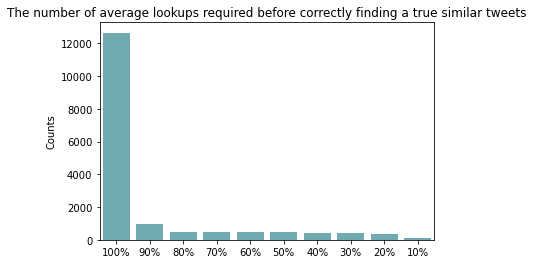

In [26]:
def compare_number_of_avg_lookups(reduces, title): 
    layer = sns.barplot(x=PLOT_X, y=reduces, color="#66B3BA")
    layer.set(ylabel='Counts')
    plt.title(title)
    plt.show()

avg_lookups = []
for i in range(len(QUERY_LOOKUPS_COL)):
    avg_lookup = np.average(np.array(correct_searches[i][QUERY_LOOKUPS_COL[i]]))
    avg_lookups.append(avg_lookup)

compare_number_of_avg_lookups(avg_lookups, 'The number of average lookups required before correctly finding a true similar tweets')

In [27]:
reduces = []
print('Comparing to using all the terms:')
for i in range(len(avg_lookups)):
    if i != 0:
        reduce = round(((avg_lookups[0] - avg_lookups[i]) / avg_lookups[0]) * 100, 2)
        reduces.append(reduce)
        chance = PLOT_X[i]
        print('By using {} of terms, {}% less lookups are needed for correctly finding a true similar tweets'.format(chance, reduce))

Comparing to using all the terms:
By using 90% of terms, 92.5% less lookups are needed for correctly finding a true similar tweets
By using 80% of terms, 96.44% less lookups are needed for correctly finding a true similar tweets
By using 70% of terms, 96.28% less lookups are needed for correctly finding a true similar tweets
By using 60% of terms, 96.31% less lookups are needed for correctly finding a true similar tweets
By using 50% of terms, 96.29% less lookups are needed for correctly finding a true similar tweets
By using 40% of terms, 96.48% less lookups are needed for correctly finding a true similar tweets
By using 30% of terms, 96.72% less lookups are needed for correctly finding a true similar tweets
By using 20% of terms, 97.12% less lookups are needed for correctly finding a true similar tweets
By using 10% of terms, 99.26% less lookups are needed for correctly finding a true similar tweets


## Index time comparison

In [28]:
index_time = results['index_time']
index_time

,Index_time_run1_100%,Index_time_run2_100%,Index_time_run3_100%,Index_time_run1_90%,Index_time_run2_90%,Index_time_run3_90%,Index_time_run1_80%,Index_time_run2_80%,Index_time_run3_80%,Index_time_run1_70%,...,Index_time_run3_40%,Index_time_run1_30%,Index_time_run2_30%,Index_time_run3_30%,Index_time_run1_20%,Index_time_run2_20%,Index_time_run3_20%,Index_time_run1_10%,Index_time_run2_10%,Index_time_run3_10%
0,35.4835,45.2134,41.3758,34.7467,29.6236,40.2607,41.3860,35.5359,37.2102,34.9569,...,54.3956,65.6123,62.7601,71.6651,89.6409,74.3126,109.2151,84.1552,84.9436,83.1159
1,31.2882,30.4180,30.4045,16.3745,17.3295,21.8143,17.5437,16.0365,19.4839,19.0103,...,35.1393,34.6078,32.4314,33.8361,31.9634,33.9890,42.7656,46.0113,48.4338,40.4776
2,24.6234,27.4449,26.0326,21.4318,22.6845,26.0241,22.9110,25.0144,19.7998,20.8261,...,21.2858,24.0385,23.8013,21.0295,25.5558,34.2673,28.7715,41.5228,42.5785,48.9692
3,18.9515,21.7850,21.3901,12.7438,12.2681,11.4984,16.6783,15.2626,12.8403,13.2825,...,20.6065,21.9237,19.9891,20.9284,28.7148,29.9861,31.8460,31.8950,31.4502,34.6084
4,24.2971,20.8491,20.3288,12.2416,11.9157,11.9893,14.5182,13.6849,13.1284,14.3960,...,22.1375,25.2199,22.2693,26.4623,26.2813,22.8743,28.4346,30.4505,31.6035,29.5273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,11.4453,17.0441,10.4108,5.1094,5.7853,10.4669,5.7303,6.0536,7.2123,6.2591,...,9.5560,12.9068,12.0040,15.6176,16.8366,18.2151,16.2523,25.3069,26.6911,21.3128
193,11.2986,12.2382,10.2667,5.2714,6.8588,9.5542,5.7343,6.1320,7.3889,6.3627,...,9.6497,11.9586,12.1099,17.4466,16.0982,17.4192,15.4462,25.1173,26.5801,20.9441
194,11.0515,10.9693,10.2238,5.6085,6.4050,10.0298,5.7447,5.9895,7.3516,6.4034,...,9.6659,11.7185,12.5356,16.0790,16.7543,18.0887,15.7816,29.2215,44.8492,22.2849
195,10.5559,11.1605,13.1823,5.0915,6.1402,9.9780,5.7247,5.9488,7.1960,6.2953,...,9.3300,11.4702,11.5283,14.6589,15.7839,16.6275,15.0732,24.8715,26.5026,18.5892


By using 100% of terms, the average time for indexing 1000 tweets is 14.6065 milliseconds
By using 90% of terms, the average time for indexing 1000 tweets is 8.3173 milliseconds
By using 80% of terms, the average time for indexing 1000 tweets is 8.6575 milliseconds
By using 70% of terms, the average time for indexing 1000 tweets is 9.0626 milliseconds
By using 60% of terms, the average time for indexing 1000 tweets is 10.5847 milliseconds
By using 50% of terms, the average time for indexing 1000 tweets is 11.5139 milliseconds
By using 40% of terms, the average time for indexing 1000 tweets is 12.4559 milliseconds
By using 30% of terms, the average time for indexing 1000 tweets is 15.3114 milliseconds
By using 20% of terms, the average time for indexing 1000 tweets is 20.022 milliseconds
By using 10% of terms, the average time for indexing 1000 tweets is 26.308 milliseconds


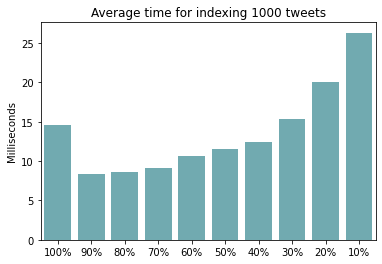

In [29]:
def compare_time(avg_time, title): 
    layer = sns.barplot(x=PLOT_X, y=avg_time, color="#66B3BA")
    layer.set(ylabel='Milliseconds')
    plt.title(title)
    plt.show()

index_time_avgs = []
for col in index_time.columns:
    index_time_avgs.append(np.average(np.array(index_time[col])))

index_time_avgs2 = []
c = 0
acc = 0
for avg in index_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        index_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(index_time_avgs2)):
    print('By using {} of terms, the average time for indexing {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, index_time_avgs2[i]))
compare_time(index_time_avgs2, 'Average time for indexing {} tweets'.format(INDEX_TIME_UNIT))

## Query time comparison

In [30]:
query_time = results['query_time']
query_time

,Query_time_run1_100%,Query_time_run2_100%,Query_time_run3_100%,Query_time_run1_90%,Query_time_run2_90%,Query_time_run3_90%,Query_time_run1_80%,Query_time_run2_80%,Query_time_run3_80%,Query_time_run1_70%,...,Query_time_run3_40%,Query_time_run1_30%,Query_time_run2_30%,Query_time_run3_30%,Query_time_run1_20%,Query_time_run2_20%,Query_time_run3_20%,Query_time_run1_10%,Query_time_run2_10%,Query_time_run3_10%
0,4.2081,4.7856,4.0215,0.5381,0.3157,0.3498,0.4229,0.2882,0.2938,0.3600,...,0.3570,1.4819,1.7338,1.3811,1.3513,1.9013,1.5754,1.8690,1.2925,2.7024
1,133.2337,153.3795,144.2512,48.7335,53.7120,56.1951,29.4237,31.1403,30.4720,29.8386,...,32.3463,35.1265,33.5483,33.8218,36.7223,38.8748,36.4787,38.9740,38.6981,34.2929
2,54.7810,225.8422,60.0921,26.4409,26.3211,25.0539,21.4639,23.0472,23.3105,24.7604,...,28.2848,34.2319,34.1079,34.4144,79.4638,33.7076,33.8890,40.0128,36.4567,34.9752
3,55.2064,77.2388,57.5514,25.4938,24.8911,27.7115,23.1464,24.5397,22.8016,22.0002,...,27.6847,28.7841,28.5390,26.3784,38.6523,29.1211,27.5275,32.6851,31.7218,28.1044
4,59.2368,71.1097,63.4490,21.6327,20.0457,21.0748,24.4960,23.5283,10.7917,25.0982,...,26.9344,28.1790,27.8113,26.3500,34.0058,28.2247,19.5780,32.3643,37.5813,30.4205
5,58.4813,73.5551,63.2128,14.1210,13.9498,13.6634,19.2588,24.8578,11.4247,25.8421,...,17.8005,28.6508,26.5004,27.5989,24.4151,20.1945,18.8379,29.1884,26.6434,25.1800
6,86.3804,91.0340,92.2948,18.4243,16.0862,16.7692,12.6589,15.2808,12.2537,34.6831,...,14.9488,24.1683,22.7123,23.0908,30.0481,21.3289,20.4763,29.9338,27.8254,59.5605
7,109.3637,117.7572,115.1626,19.0704,17.9664,18.4440,11.9356,12.0521,11.8766,25.9047,...,16.1212,17.2868,17.5465,17.3461,25.3198,22.4485,21.3697,26.9054,27.1436,29.0565
8,93.3910,96.0072,97.9405,17.3322,17.5240,16.2093,16.8314,11.8815,12.7309,12.5122,...,74.1754,17.5161,17.6134,17.1698,24.1604,20.8611,19.9092,22.8157,25.9817,28.3973
9,87.9173,97.1558,92.6156,18.1241,15.2282,14.7026,14.2598,12.8114,12.4468,12.5744,...,17.8108,16.8550,17.3957,16.8887,22.7847,20.3341,18.9839,24.0832,25.8529,27.5405


By using 100% of terms, the average time for querying 1000 tweets is 68.4265 milliseconds
By using 90% of terms, the average time for querying 1000 tweets is 14.8704 milliseconds
By using 80% of terms, the average time for querying 1000 tweets is 12.2982 milliseconds
By using 70% of terms, the average time for querying 1000 tweets is 14.005 milliseconds
By using 60% of terms, the average time for querying 1000 tweets is 16.8381 milliseconds
By using 50% of terms, the average time for querying 1000 tweets is 16.1665 milliseconds
By using 40% of terms, the average time for querying 1000 tweets is 19.586 milliseconds
By using 30% of terms, the average time for querying 1000 tweets is 18.9977 milliseconds
By using 20% of terms, the average time for querying 1000 tweets is 23.6531 milliseconds
By using 10% of terms, the average time for querying 1000 tweets is 27.6155 milliseconds


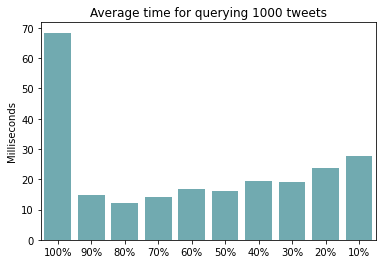

In [31]:
query_time_avgs = []
for col in query_time.columns:
    query_time_avgs.append(np.average(np.array(query_time[col])))

query_time_avgs2 = []
c = 0
acc = 0
for avg in query_time_avgs:
    if c < 2:
        acc += avg
        c += 1
        
    else:
        acc += avg
#         print(acc)
        query_time_avgs2.append(round(acc/3 , 4))
        acc = 0
        c = 0

for i in range(len(query_time_avgs2)):
    print('By using {} of terms, the average time for querying {} tweets is {} milliseconds'.format(PLOT_X[i], INDEX_TIME_UNIT, query_time_avgs2[i]))
compare_time(query_time_avgs2, 'Average time for querying {} tweets'.format(INDEX_TIME_UNIT))